# Long photoreceptor variability

In [1]:
from typing import List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.lines import Line2D 
import seaborn as sns
import itertools
from sklearn.linear_model import LinearRegression
from scipy.stats import zscore

import sys
from cx_analysis.dataframe_tools import assemble_cxvectors
from cx_analysis.vis.hex_lattice import hexplot
from cx_analysis.vis.fig_tools import linear_cmap, subtype_cm, shortened_st


In [3]:
plt.rcdefaults()
plt.style.use('../cx_analysis/vis/lamina.mplstyle') # may not work if installed as a module

### SAVE FIGS? ###
save_figs = True

fig_path = '/mnt/home/nchua/Dropbox/lamina_figures/210709/'

In [4]:
# Load dataframe of om->[connection counts]
tp = '210809'
lamina_links = pd.read_pickle(f'~/Data/{tp}_lamina/{tp}_linkdf.pickle')
subtypes = np.unique([*lamina_links["pre_type"], *lamina_links["post_type"]])

all_ctypes = [p for p in itertools.product(subtypes, subtypes)]  
all_ctype_labels = [f"{pre}->{post}" for pre, post in all_ctypes]
ommatidia = ommatidia = np.unique(lamina_links['pre_om'])

cxvecs = assemble_cxvectors(lamina_links)  # each om has a vector of connection counts

In [6]:
# Connection types with a mean count of less than thresh are filtered out
thresh = 0.0

cxvecs = cxvecs.loc[:, cxvecs.mean() > thresh].fillna(0)  # filter out connections with mean less than 1
cxvecs = cxvecs.rename_axis(index='om')

dra_om = ['A4', 'A5', 'B5', 'B6', 'C5', 'C6', 'D6', 'D7', 'E6', 'E7']
ndra_om = [o for o in ommatidia if o not in dra_om]
assert(len(dra_om) + len(ndra_om) == 29)
# Colors and marker styles of the different retinotopic groups
dra_c = '#434371'
ndra_c = '#C64191'
dra_m = '^'
ndra_m = 'v'
# Dict with color for each cell subtypes
st_cm = subtype_cm()

In [7]:
# Specifies colors for DRA and non-DRA ommatidia
def om_colors(om_list: List, dra_om: List=dra_om, as_rgb: bool=False, 
              dra_c: str=dra_c, ndra_c: str=ndra_c) -> List:
    
    c_list = []
    for o in om_list:
        if str(o) in dra_om:
            c_list.append(dra_c)
        else:
            c_list.append(ndra_c)
    if as_rgb:
        return [tuple(int(h.lstrip('#')[i:i+2], 16)/255.0 for i in (0, 2, 4)) for h in c_list] 
    else:
        return c_list
    
def om_markers(om_list: List, dra_om: List=dra_om, 
               dra_m: str=dra_m, ndra_m: str=ndra_m) -> List:
    
    m_list = []
    for o in om_list:
        if o in dra_om:
            m_list.append(dra_m)
        else:
            m_list.append(ndra_m)
            
    return m_list

## Number of lamina inputs to R7 and R8

Text(0, 0.5, '# synaptic inputs to R8')

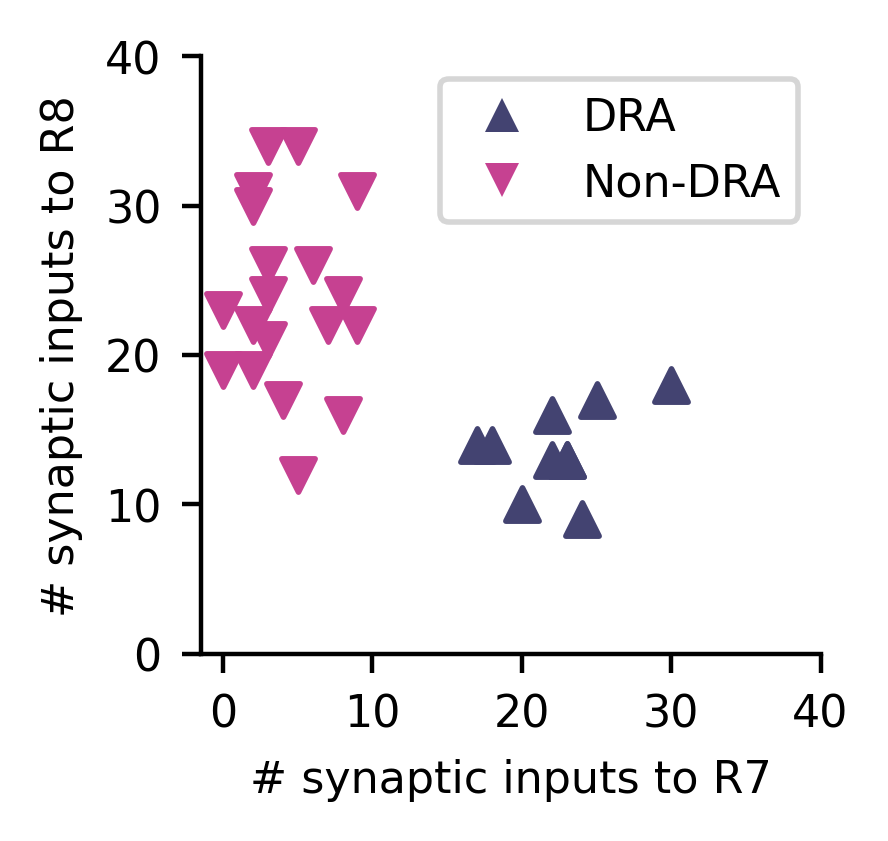

In [8]:
fig, ax = plt.subplots(1, figsize=[2, 2])
x = cxvecs.filter(regex='->R7$').sum(axis=1)
y = cxvecs.filter(regex='->R8$').sum(axis=1)

for o in ommatidia: 
    if o in dra_om:
        ax.scatter(x=x.loc[o], y=y.loc[o], color=dra_c, marker=dra_m, alpha=1.0)
    else:
        ax.scatter(x=x.loc[o], y=y.loc[o], color=ndra_c, marker=ndra_m, alpha=1.0)

legend_elements = [Line2D([0], [0], lw=0, color=dra_c, marker=dra_m, label='DRA'), 
                   Line2D([0], [0], lw=0, color=ndra_c, marker=ndra_m, label='Non-DRA')]

ax.legend(handles=legend_elements)
ax.set_title('')

ax.set_xticks(np.arange(0, 40+1, 10))
ax.set_yticks(np.arange(0, 40+1, 10))

ax.set_aspect('equal')
ax.set_xlabel('# synaptic inputs to R7')
ax.set_ylabel('# synaptic inputs to R8')

In [19]:
if save_figs:
    fig.savefig(fig_path + 'R7R8_inputs.svg')
    fig.savefig(fig_path + 'R7R8_inputs.png')

10.517241379310345

9.144889998226718

20.344827586206897

6.989035067673508

46.827586206896555

12.34020333347607

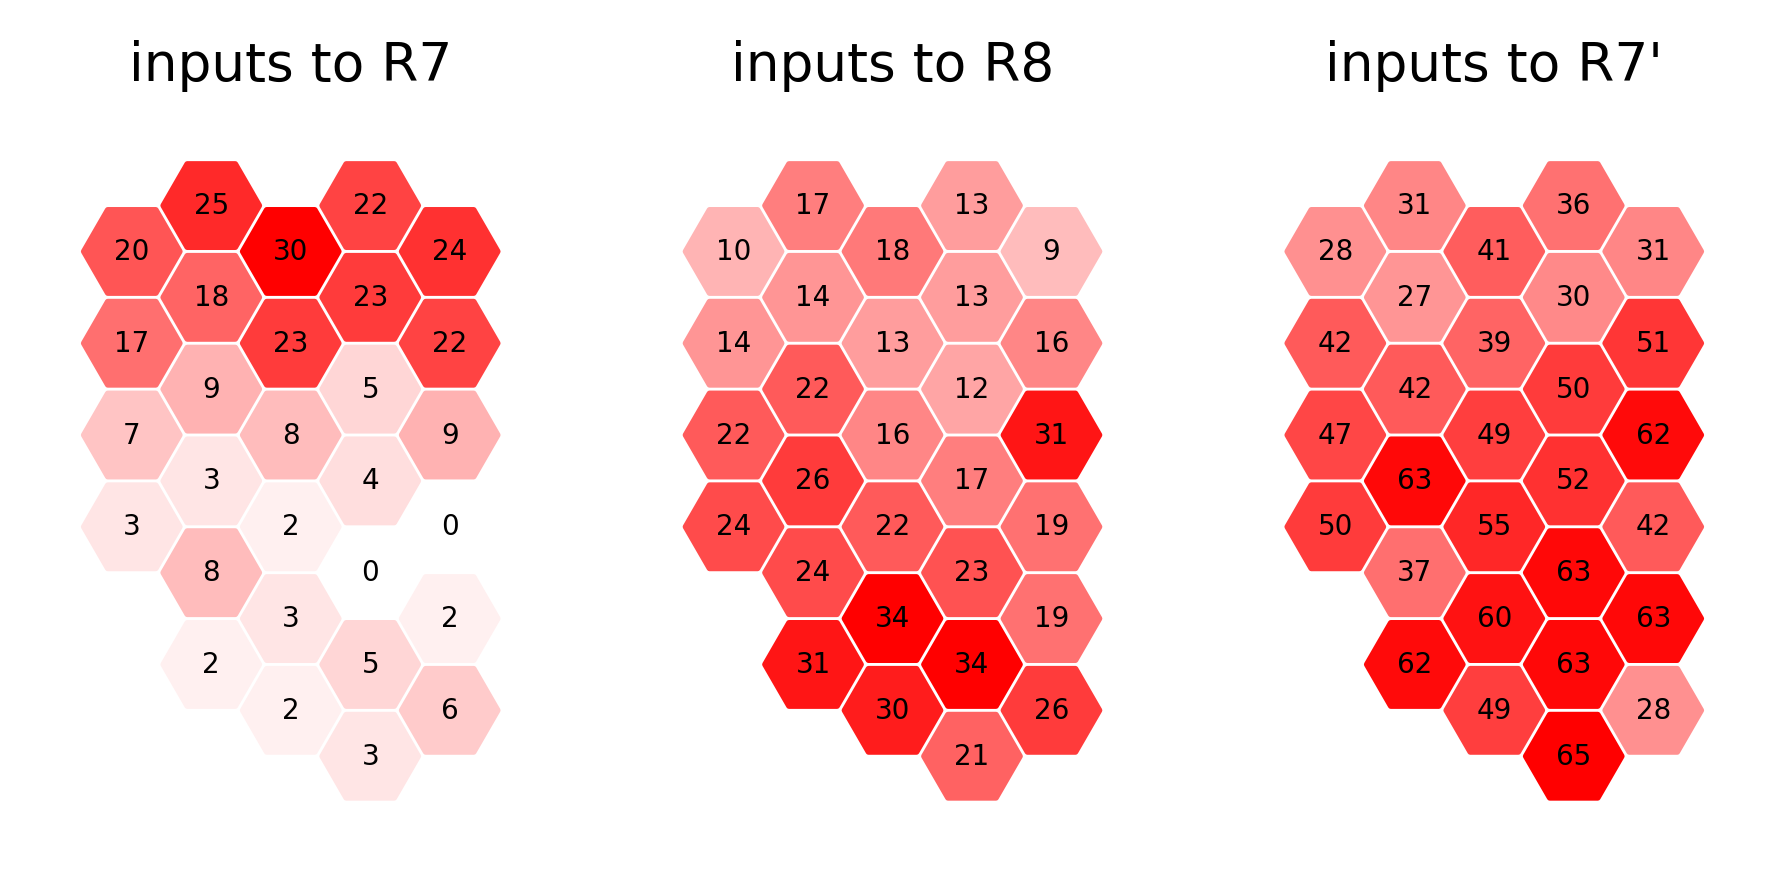

In [20]:
fig, ax = plt.subplots(1, 3, figsize=[5.5, 3])
lincm = linear_cmap(n_vals=100, max_colour='r')

cbar_max_is_indv_max = True

data = {'R7': cxvecs.filter(regex='->R7$').sum(axis=1), 
        'R8': cxvecs.filter(regex='->R8$').sum(axis=1), 
        "R7'": cxvecs.filter(regex='->R7p$').sum(axis=1)}

if not cbar_max_is_indv_max:  
    # use largest value across subtypes for cbar
    max_val = max([*data['R7'], *data['R8'], *data["R7'"]])
    
i = 0
for post, totals in data.items():
    
    if cbar_max_is_indv_max:
        max_val = totals.max()
    
    node_data = {om: {'colour': lincm(v/max_val), 
                      'label': v} for om, v in totals.items()}
    display(totals.mean())
    display(totals.std(ddof=0))
    hexplot(node_data, ax=ax[i])
    ax[i].set_title(f'inputs to {post}')
    i += 1




In [21]:
if save_figs:
    fig.savefig(fig_path + 'R7R8_inputs_hex.svg')
    fig.savefig(fig_path + 'R7R8_inputs_hex.png')

Text(0.5, 1.0, "R7 + R8 + R7'")

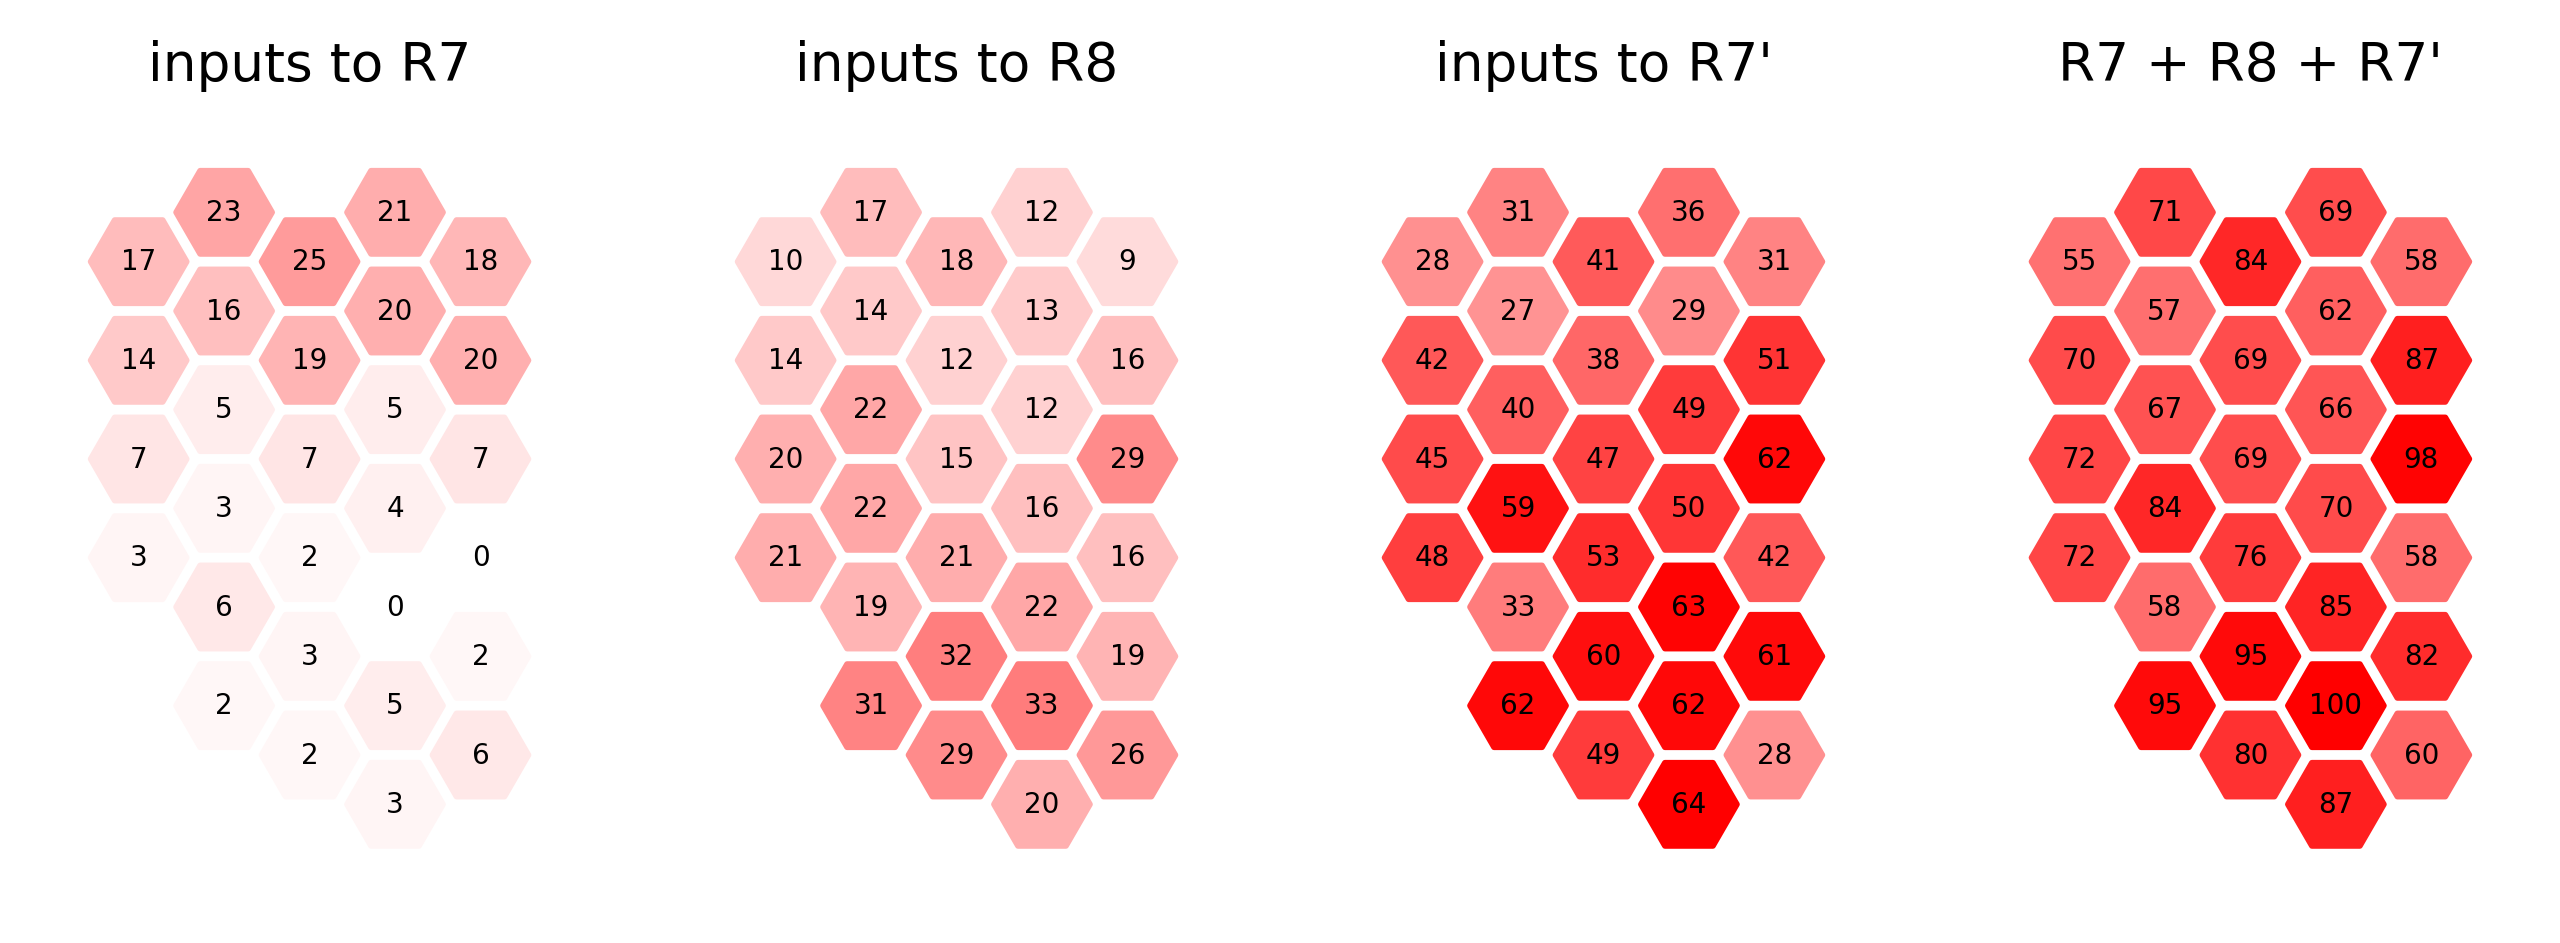

In [128]:
fig, ax = plt.subplots(1, 4, figsize=[8, 3])
lincm = linear_cmap(n_vals=100, max_colour='r')

data = {'R7': cxvecs.filter(regex='->R7$').sum(axis=1), 
        'R8': cxvecs.filter(regex='->R8$').sum(axis=1), 
        "R7'": cxvecs.filter(regex='->R7p$').sum(axis=1)}
global_max = max([*data['R7'], *data['R8'], *data["R7'"]])
i = 0
for post, totals in data.items():
    node_data = {om: {'colour': lincm(v/global_max), 
                      'label': v} for om, v in totals.items()}
    hexplot(node_data, ax=ax[i])
    ax[i].set_title(f'inputs to {post}')
    i += 1
    
# total inputs to R7+R8+R7'
all_totals = data['R7'] + data['R8'] + data["R7'"]
node_data = {om: {'colour': lincm(v/all_totals.max()), 
                 'label': v} for om, v in all_totals.items()}
hexplot(node_data, ax[3])
ax[3].set_title("R7 + R8 + R7'")




Text(0.5, 1.0, "R7 + R8 + R7'")

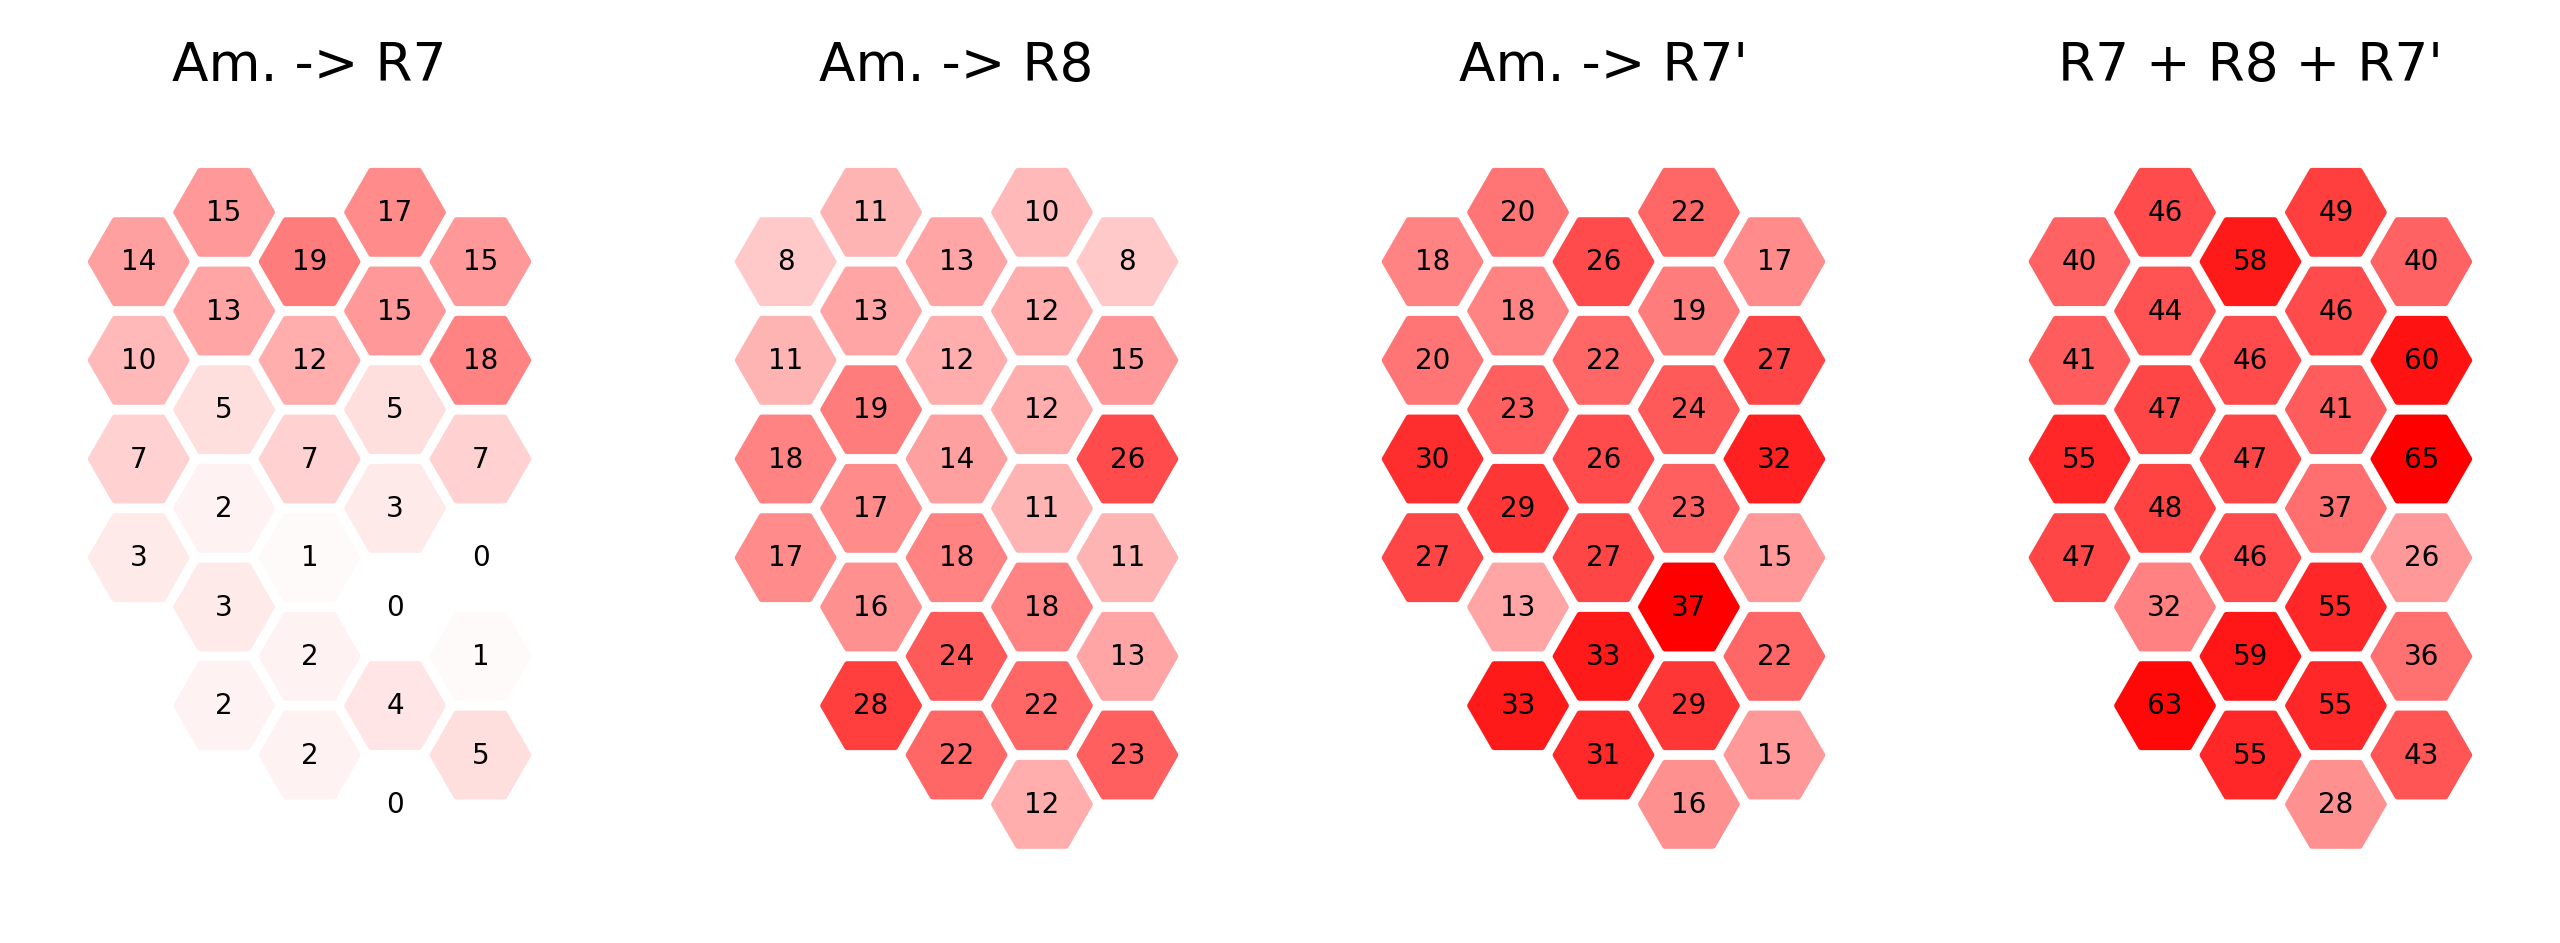

In [130]:
fig, ax = plt.subplots(1, 4, figsize=[8, 3])
lincm = linear_cmap(n_vals=100, max_colour='r')

data = {'R7': cxvecs['centri->R7'], 
        'R8': cxvecs['centri->R8'], 
        "R7'": cxvecs['centri->R7p']}
global_max = max([*data['R7'], *data['R8'], *data["R7'"]])
i = 0
for post, totals in data.items():
    node_data = {om: {'colour': lincm(v/global_max), 
                      'label': v} for om, v in totals.items()}
    hexplot(node_data, ax=ax[i])
    ax[i].set_title(f'Am. -> {post}')
    i += 1
    
# total inputs to R7+R8+R7'
all_totals = data['R7'] + data['R8'] + data["R7'"]
node_data = {om: {'colour': lincm(v/all_totals.max()), 
                 'label': v} for om, v in all_totals.items()}
hexplot(node_data, ax[3])
ax[3].set_title("R7 + R8 + R7'")

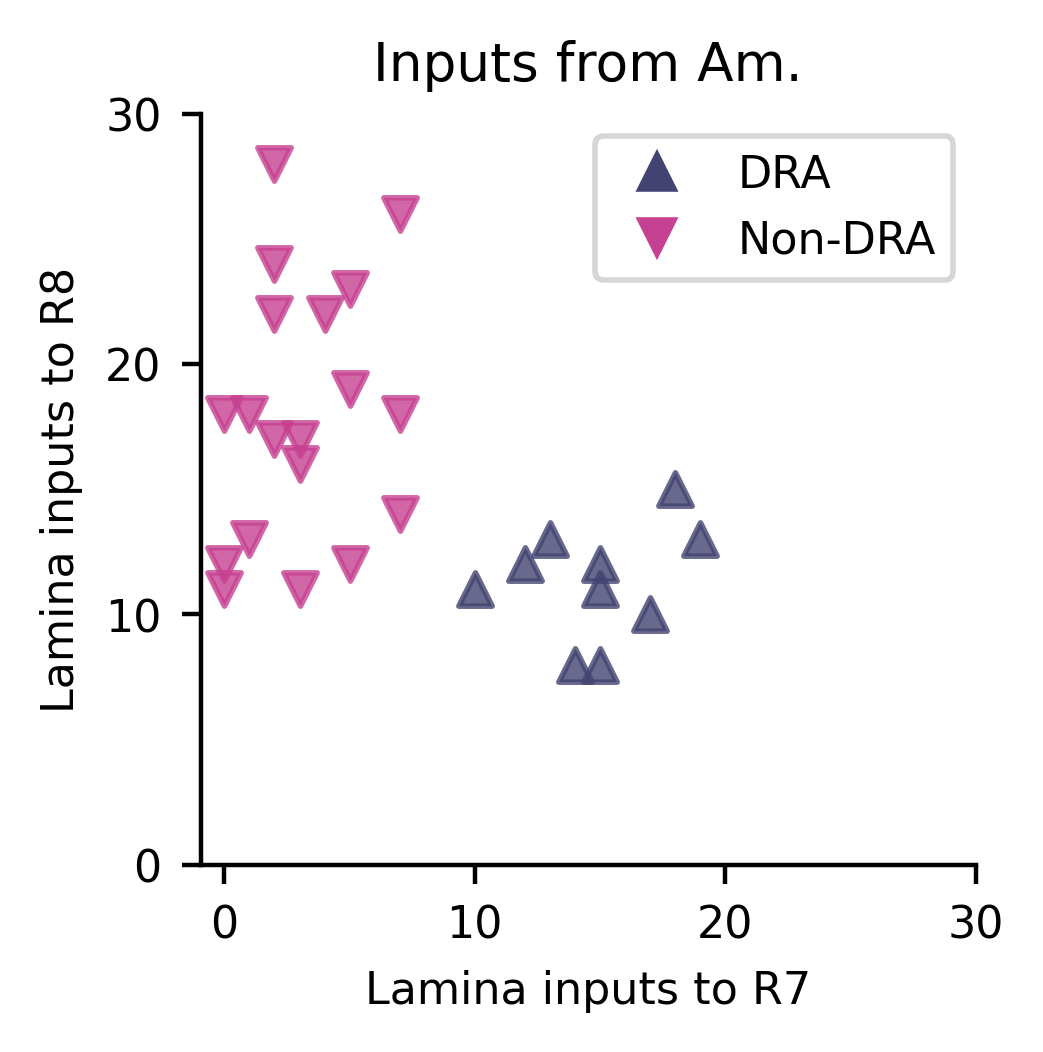

In [109]:
fig, ax = plt.subplots(1, figsize=[2.5, 2.5])
x = cxvecs.filter(regex='centri->R7$').sum(axis=1)
y = cxvecs.filter(regex='centri->R8$').sum(axis=1)

for o in ommatidia: 
    if o in dra_om:
        ax.scatter(x=x.loc[o], y=y.loc[o], color=dra_c, marker=dra_m, alpha=0.8)
    else:
        ax.scatter(x=x.loc[o], y=y.loc[o], color=ndra_c, marker=ndra_m, alpha=0.8)

legend_elements = [Line2D([0], [0], lw=0, color=dra_c, marker=dra_m, label='DRA'), 
                   Line2D([0], [0], lw=0, color=ndra_c, marker=ndra_m, label='Non-DRA')]

ax.legend(handles=legend_elements)
ax.set_title('Inputs from Am.')

# ax.set_xlim([0, 30])
# ax.set_ylim([0, 30])

ax.set_xticks(np.arange(0, 30+1, 10))
ax.set_yticks(np.arange(0, 30+1, 10))

ax.set_aspect('equal')
ax.set_xlabel('Lamina inputs to R7')
ax.set_ylabel('Lamina inputs to R8')

plt.show()

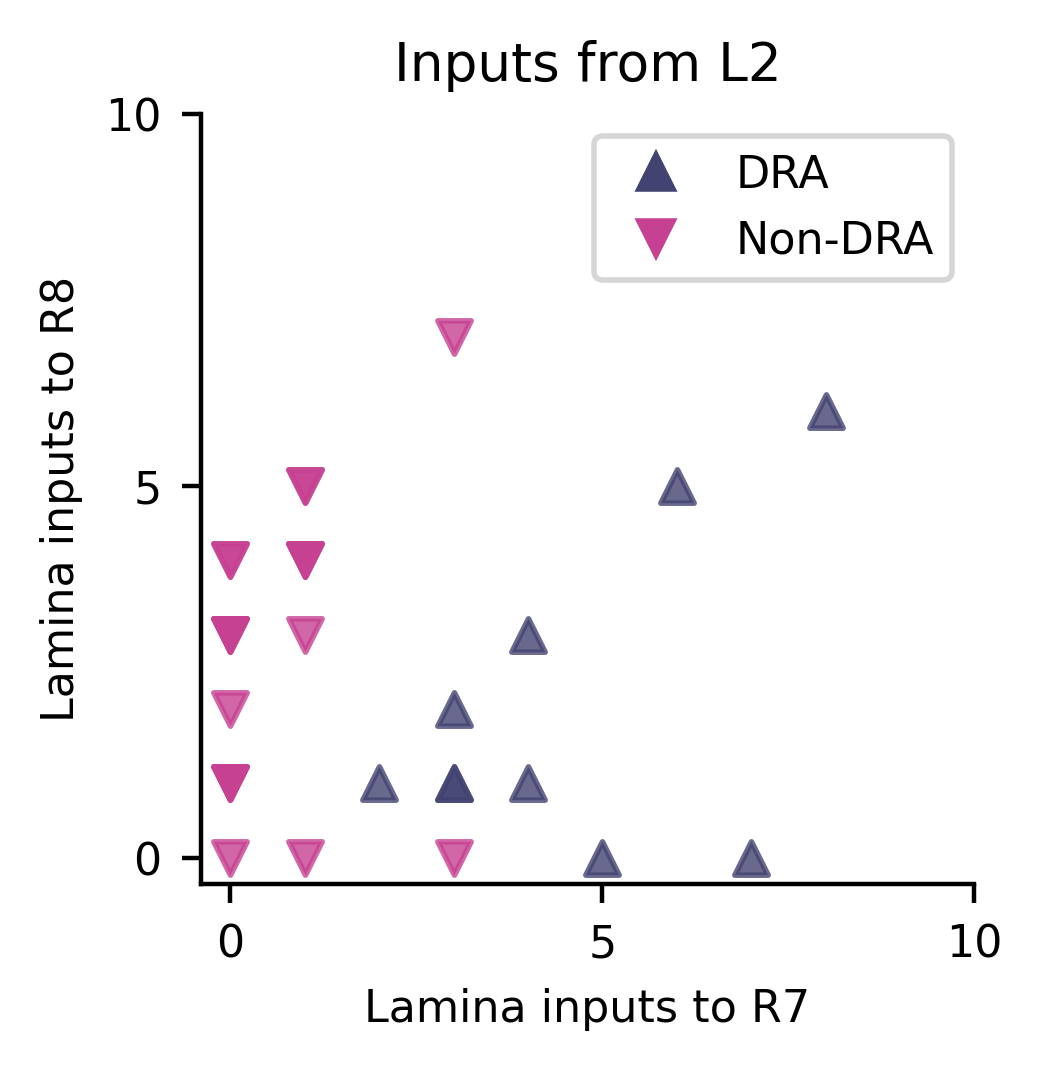

In [114]:
fig, ax = plt.subplots(1, figsize=[2.5, 2.5])
x = cxvecs.filter(regex='LMC_2->R7$').sum(axis=1)
y = cxvecs.filter(regex='LMC_2->R8$').sum(axis=1)

for o in ommatidia: 
    if o in dra_om:
        ax.scatter(x=x.loc[o], y=y.loc[o], color=dra_c, marker=dra_m, alpha=0.8)
    else:
        ax.scatter(x=x.loc[o], y=y.loc[o], color=ndra_c, marker=ndra_m, alpha=0.8)

legend_elements = [Line2D([0], [0], lw=0, color=dra_c, marker=dra_m, label='DRA'), 
                   Line2D([0], [0], lw=0, color=ndra_c, marker=ndra_m, label='Non-DRA')]

ax.legend(handles=legend_elements)
ax.set_title('Inputs from L2')

# ax.set_xlim([0, 30])
# ax.set_ylim([0, 30])

ax.set_xticks(np.arange(0, 10+1, 5))
ax.set_yticks(np.arange(0, 10+1, 5))

ax.set_aspect('equal')
ax.set_xlabel('Lamina inputs to R7')
ax.set_ylabel('Lamina inputs to R8')

plt.show()